# This notebook is an example notebook to inference the latent diffusion model.

In [30]:
import argparse, os, sys, glob
sys.path.append(os.getcwd()+"/ldm")
from omegaconf import OmegaConf
from PIL import Image, ImageDraw, ImageFilter
from tqdm import tqdm
import numpy as np
import torch
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from torch.utils.data import Dataset, DataLoader
import os, sys, yaml, pickle, shutil, tarfile, glob
import cv2
import albumentations
import numpy as np
import torchvision.transforms.functional as TF
from omegaconf import OmegaConf
from functools import partial
from PIL import Image
from tqdm import tqdm
import copy
import os
import torch
from torch.utils.data import Dataset, Subset
import random
import matplotlib.pyplot as plt

import torchvision.transforms as T
transform_PIL = T.ToPILImage()

import uuid

In [2]:
# config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# yaml_path="/mayo_atlas/home/m288756/latent-diffusion-inpainting/ldm/models/ldm/inpainting_big/config.yaml"
# model_path="ldm/models/ldm/inpainting_big/last.ckpt"
# model_path="/mayo_atlas/home/m288756/latent-diffusion-inpainting/logs/checkpoints/last.ckpt"

yaml_path="/mayo_atlas/home/m288756/stable-diffusion/models/ldm/inpainting_big/config.yaml"
# model_path="/mayo_atlas/home/m288756/stable-diffusion/models/ldm/inpainting_big/last.ckpt"
# model_path="/mayo_atlas/home/m288756/latent-diffusion-inpainting/ldm/models/ldm/inpainting_big/new_model.ckpt"
# model_path="/mayo_atlas/home/m288756/stable-diffusion/logs2/checkpoints/last.ckpt"
# model_path="/mayo_atlas/home/m288756/stable-diffusion/logs/checkpoints/last2.ckpt"
model_path="/home/m288756/stable-diffusion/someCheckpoints/last1million1epoch.ckpt"

In [3]:
##create model
def create_model(device):
    
    #load config and checkpoint
    config = OmegaConf.load(yaml_path)
    config.model['params']['ckpt_path']=model_path
    
    model = instantiate_from_config(config.model)
    sampler = DDIMSampler(model)
    model = model.to(device)

    return model,sampler

In [38]:
def random_rectangle_mask(image):
    # Create a copy of the original image
    masked_image = image.copy()
    masked_image2 = image.copy()
    image_x, image_y = image.size
    
    # width = random.randint(70, 150)
    width = random.randint(200, 300)
    print(width)
    height = int(width * random.uniform(0.7, 1.5))
    
    
    # Create a black background mask
    mask = Image.new('L', (image_x, image_y), 0)
    mask2 = mask.copy()
    draw = ImageDraw.Draw(mask)
    

    # Randomly generate the coordinates for the top-left and bottom-right corners of the rectangle
    x1 = random.randint(0, image.size[0] - width)
    y1 = random.randint(0, image.size[1] - height)
    x2 = x1 + width
    y2 = y1 + height

    # Draw a white rectangle on the mask
    draw.rectangle([x1, y1, x2, y2], fill=255)

    # # Apply the mask to the original image
    masked_image.paste(Image.new('RGB', (image_x, image_y), (0, 0, 0)), mask=mask)
    
    
    # get the region of interest
    region = image.crop((x1, y1, x2, y2))
    
    # get the entire image where the background is masked while the region of interest is not
    mask2.paste(region, (x1, y1, x2, y2))
    
    
    


    return image, mask, masked_image, region, mask2


In [39]:
def random_crop(region, percentage):
        h, w, _ = region.shape
        min_size = min(h, w)
        new_h, new_w = int(min_size * percentage), int(min_size * percentage)
        
        top = random.randint(0, h - new_h)
        left = random.randint(0, w - new_w)

        cropped = region[top: top + new_h, left: left + new_w, :]

        print(f'region after crop: {cropped.shape}')
        return cropped

def process_data(image,mask,size=512):

    # creating a 3 dimensional mask
    mask = np.array(mask)
    mask = np.expand_dims(mask, axis=2)

    # normalzie and transform the image into tensor
    image = np.array(image.convert("RGB"))
    image = cv2.resize(image, (size, size))
    
    # image_base = image.astype(np.float32) / 255.0#
    image = image.astype(np.float32) / 255.0#
    image_base = image.copy()
    # image = image[None].transpose(0,3,1,2)
    image = torch.from_numpy(image)

    
    # normalzie and transform the mask into tensor
    mask = mask.astype(np.float32) / 255.0#
    mask[mask < 0.1] = 0
    mask[mask >= 0.1] = 1
#     maskbase = mask[None].transpose(0,3,1,2)

    
    # produce the masked image by subtraction
    # mask = mask[None].transpose(0,3,1,2)
    maskbase = mask.copy()
    mask = torch.from_numpy(mask)

#     mask = torch.from_numpy(maskbase)
#     image = image_base[None].transpose(0,3,1,2)
#     image = torch.from_numpy(image)
    # masked_image = (1 - mask) * image


    # Find bounding box of the masked region
    non_zero_indices = torch.nonzero(mask, as_tuple=False)
    if non_zero_indices.numel() > 0:
        min_yx = torch.min(non_zero_indices, dim=0)[0]
        max_yx = torch.max(non_zero_indices, dim=0)[0]
        min_y, min_x = min_yx[0], min_yx[1]
        max_y, max_x = max_yx[0], max_yx[1]

        # Ensure minimum width and height of 30 pixels
        if max_y - min_y < 30:
            center_y = (max_y + min_y) // 2
            min_y = max(center_y - 15, 0)
            max_y = min(center_y + 15, size - 1)

        if max_x - min_x < 30:
            center_x = (max_x + min_x) // 2
            min_x = max(center_x - 15, 0)
            max_x = min(center_x + 15, size - 1)

        # Crop the region from the original image
        cropped_region = image[min_y:max_y+1, min_x:max_x+1, :]
    else:
        # If there are no nonzero indices, crop a 30x30 region from the center of the mask location
        center_y, center_x = size // 2, size // 2
        min_y = max(center_y - 15, 0)
        max_y = min(center_y + 15, size - 1)
        min_x = max(center_x - 15, 0)
        max_x = min(center_x + 15, size - 1)
        # print("No nonzero indices crop -------------------")

        cropped_region = image[min_y:max_y+1, min_x:max_x+1, :]
    
    
    print(f'cropped region {cropped_region.shape}')
    print(f'image {image.shape}')
    print(f'mask {mask.shape}')
    
    
    # Randomly crop between 50% and 100% of the cropped_region
    crop_percentage = random.uniform(0.5, 0.8)
    # print(f'crop percentage: {crop_percentage}')
    cropped_region = random_crop(cropped_region, crop_percentage)

    # now resize the cropped_region to 512x512
    cropped_region2 = cv2.resize(np.array(cropped_region), (size, size))

    print(f'cropped region2 {cropped_region2.shape}')

    # print(f'masked image {masked_image.shape}')


    # image = image_base[None].transpose(0,3,1,2)
    # image = torch.from_numpy(image)
    # print(f'maskbase {maskbase.shape}')
    # mask = maskbase[None].transpose(0,3,1,2)
    mask = torch.from_numpy(maskbase)
    # cropped_region2 = torch.from_numpy(cropped_region2)
    cropped_region2 = torch.from_numpy(cropped_region2[None]) #.transpose(0,3,1,2)
    

    print("-----------------------------")
    print(f'cropped region2 {cropped_region2.shape}')
    print(f'image {image.shape}')
    print(f'mask {mask.shape}')
    
    image = image[None]
    mask = mask[None]
    
    image = image.permute(0,3,1,2)
    cropped_region2 = cropped_region2.permute(0,3,1,2)
    mask = mask.permute(0,3,1,2)
    

    
    
    print("-----------------------------")
    print(f'cropped region2 {cropped_region2.shape}')
    print(f'image {image.shape}')
    print(f'mask {mask.shape}')

    # batch = {"image_tensor": image, "mask_tensor": mask, "masked_image_tensor": masked_image}
    batch = {"image_tensor": image, "mask_tensor": mask, "masked_image_tensor": cropped_region2}
    
    
    for k in batch:
        batch[k] = batch[k] * 2.0 - 1.0

    return batch

In [ ]:
load_image=Image.open("/mayo_atlas/home/m288756/stable-diffusion/data/oneImage/TCGA-22-A5C4-01Z-00-DX1.54058689-5CA5-4F92-B18A-86208C24C87D_18432_47104.jpg") #.resize((512,512))
image_resized = load_image.copy().resize((512,512))
image,mask, maskedImage=random_rectangle_mask(image_resized)
batch, batchAll = process_dataMine(load_image,mask,size=512)

image_tensor=batchAll["image"]
mask_tensor=batchAll["mask"]
masked_image_tensor=batchAll["masked_image"]
roi=batchAll["roi"]


# Save images in two rows using plt
plt.figure(figsize=(12, 8))

# First row: Original Image, Generated Mask, Masked Image
plt.subplot(2, 4, 1)
plt.imshow(image_tensor.squeeze().numpy().transpose(2,1,0))
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 4, 2)
plt.imshow(masked_image_tensor.squeeze().numpy().transpose(1,2,0))
plt.title('Masked Image')
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(mask_tensor.squeeze().numpy(), cmap='gray')
plt.title('Generated Mask')
plt.axis('off')

plt.subplot(2, 4, 4)
plt.imshow(masked_image_tensor.squeeze().numpy().transpose(1,2,0))
plt.title('Masked Image')
plt.axis('off')

plt.subplot(2, 4, 5)
plt.imshow(image_tensor.squeeze().numpy().transpose(2,1,0))
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 4, 6)
plt.imshow(masked_image_tensor.squeeze().numpy().transpose(1,2,0))
plt.title('Masked Image')
plt.axis('off')

plt.subplot(2, 4, 7)
plt.imshow(mask_tensor.squeeze().numpy(), cmap='gray')
plt.title('Generated Mask')
plt.axis('off')

plt.subplot(2, 4, 8)
plt.imshow(roi.squeeze().numpy().transpose(1,2,0))
plt.title('ROI Image')
plt.axis('off')

plt.show()

plt.savefig(f"sample_images_rows.png")
plt.close()

In [ ]:
model,sampler=create_model(device)
model.load_state_dict(torch.load('/mayo_atlas/home/m288756/stable-diffusion/models/ldm/inpainting_big/new_model.ckpt')['state_dict'])

In [ ]:
##Inference

# convert PIL image into input Torch Tensor
# batch=process_data(image,mask,size=512)
batch, batchAll = process_dataMine(image,mask,size=512)

image_tensor=batch["image"]
mask_tensor=batch["mask"]
masked_image_tensor=batch["masked_image"]


print(f'image_tensor {image_tensor.shape}'
      f'mask_tensor {mask_tensor.shape}'
      f'masked_image_tensor {masked_image_tensor.shape}')

# encode masked image and concat downsampled mask
c = model.cond_stage_model.encode(masked_image_tensor.to(device))

# the mask is frst being downsampled
cc = torch.nn.functional.interpolate(mask_tensor.to(device),
                                    size=c.shape[-2:])
# concat the masked image and downsampled mask
c = torch.cat((c, cc), dim=1)
shape = (c.shape[1]-1,)+c.shape[2:]

# shape = (3, 128, 128)
# c.shape
# diffusion process
samples_ddim, _ = sampler.sample(S=50,
                             conditioning=c,
                             batch_size=c.shape[0],
                             shape=shape,
                             verbose=False)


# decode the latent vector (output)
x_samples_ddim = model.decode_first_stage(samples_ddim)


# denormalize the output
predicted_image_clamped = torch.clamp((x_samples_ddim+1.0)/2.0,
                            min=0.0, max=1.0)


output_PIL=transform_PIL(predicted_image_clamped[0])


fig, axes = plt.subplots(1, 4, figsize=(12, 4))  # Create a 1x3 grid for displaying 3 images

# Display each image on a separate subplot
axes[0].imshow(image)
axes[0].set_title('original image')

axes[1].imshow(mask)
axes[1].set_title('masked image')

axes[2].imshow(masked_image_tensor.squeeze().numpy().transpose(1,2,0))
axes[2].set_title('ROI')

axes[3].imshow(output_PIL)
axes[3].set_title('Inpainted Image')

plt.show()

In [140]:
load_image=Image.open("/mayo_atlas/home/m288756/stable-diffusion/data/oneImage/TCGA-22-A5C4-01Z-00-DX1.54058689-5CA5-4F92-B18A-86208C24C87D_18432_47104.jpg") #.resize((512,512))
image_resized = load_image.copy().resize((512,512))
image,mask,masked_image,region=random_rectangle_mask(image_resized)
process_data(load_image,mask,size=512)

209
cropped region torch.Size([285, 210, 3])
image torch.Size([512, 512, 3])
mask torch.Size([512, 512, 1])
region after crop: torch.Size([151, 151, 3])
cropped region2 (512, 512, 3)
-----------------------------
cropped region2 torch.Size([1, 512, 512, 3])
image torch.Size([512, 512, 3])
mask torch.Size([512, 512, 1])
-----------------------------
cropped region2 torch.Size([1, 3, 512, 512])
image torch.Size([1, 3, 512, 512])
mask torch.Size([1, 1, 512, 512])


{'image_tensor': tensor([[[[ 0.4980,  0.4667,  0.5294,  ...,  0.8980,  0.8824,  0.1922],
           [ 0.5529,  0.5686,  0.6471,  ...,  0.4588,  0.8588,  0.9137],
           [ 0.4510,  0.4118,  0.7412,  ..., -0.3804,  0.0980,  0.7804],
           ...,
           [-0.4039, -0.5137, -0.3412,  ...,  0.4039,  0.3255,  0.4745],
           [ 0.0118, -0.0824,  0.3804,  ...,  0.6235,  0.4196,  0.4275],
           [ 0.3569,  0.4196,  0.2392,  ...,  0.4039,  0.4353,  0.3647]],
 
          [[ 0.0902,  0.0431,  0.0980,  ...,  0.7333,  0.7569,  0.0902],
           [ 0.1216,  0.1294,  0.1843,  ...,  0.2706,  0.7176,  0.7961],
           [ 0.0039, -0.0588,  0.2314,  ..., -0.5922, -0.0902,  0.6157],
           ...,
           [-0.6549, -0.7647, -0.5922,  ..., -0.0275, -0.0902,  0.0745],
           [-0.3176, -0.4039,  0.0745,  ...,  0.1608, -0.0353, -0.0275],
           [-0.0275,  0.0431, -0.1059,  ..., -0.0980, -0.0588, -0.1216]],
 
          [[ 0.3882,  0.3490,  0.4039,  ...,  0.9294,  0.9373,  0.2314

In [6]:
model,sampler=create_model(device)

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 387.25 M params.
Keeping EMAs of 418.
making attention of type 'none' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'none' with 512 in_channels
Using first stage also as cond stage.
Restored from /home/m288756/stable-diffusion/someCheckpoints/last1million1epoch.ckpt with 0 missing and 0 unexpected keys


In [42]:
# load_image=Image.open("/mayo_atlas/home/m288756/stable-diffusion/data/oneImage/TCGA-22-A5C4-01Z-00-DX1.54058689-5CA5-4F92-B18A-86208C24C87D_18432_47104.jpg").resize((512,512))
# image,mask,masked_image=random_rectangle_mask(load_image)

load_image=Image.open("/mayo_atlas/home/m288756/stable-diffusion/data/oneImage/TCGA-22-A5C4-01Z-00-DX1.54058689-5CA5-4F92-B18A-86208C24C87D_18432_47104.jpg") #.resize((512,512))
image_resized = load_image.copy().resize((512,512))
image,mask,masked_image,region,masked_BK=random_rectangle_mask(image_resized)

242


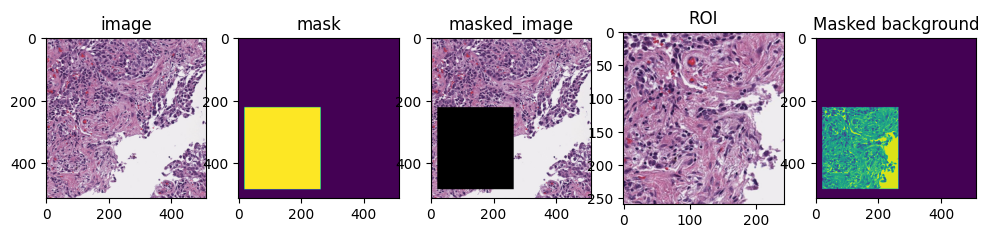

In [43]:
fig, axes = plt.subplots(1, 5, figsize=(12, 4))  # Create a 1x3 grid for displaying 3 images

# Display each image on a separate subplot
axes[0].imshow(image)
axes[0].set_title('image')

axes[1].imshow(mask)
axes[1].set_title('mask')

axes[2].imshow(masked_image)
axes[2].set_title('masked_image')

axes[3].imshow(region)
axes[3].set_title('ROI')

axes[4].imshow(masked_BK)
axes[4].set_title('Masked background')

plt.show()

cropped region torch.Size([264, 295, 3])
image torch.Size([512, 512, 3])
mask torch.Size([512, 512, 1])
region after crop: torch.Size([138, 138, 3])
cropped region2 (512, 512, 3)
-----------------------------
cropped region2 torch.Size([1, 512, 512, 3])
image torch.Size([512, 512, 3])
mask torch.Size([512, 512, 1])
-----------------------------
cropped region2 torch.Size([1, 3, 512, 512])
image torch.Size([1, 3, 512, 512])
mask torch.Size([1, 1, 512, 512])
Data shape for DDIM sampling is (1, 3, 128, 128), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:02<00:00, 23.69it/s]


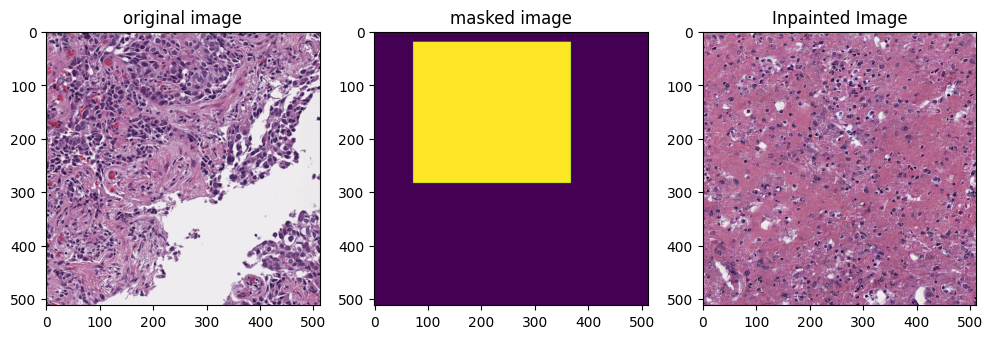

In [9]:
##Inference

# convert PIL image into input Torch Tensor
batch=process_data(image,mask,size=512)
image_tensor=batch["image_tensor"]
mask_tensor=batch["mask_tensor"]
masked_image_tensor=batch["masked_image_tensor"]


# encode masked image and concat downsampled mask
c = model.cond_stage_model.encode(masked_image_tensor.to(device))

# the mask is frst being downsampled
cc = torch.nn.functional.interpolate(mask_tensor.to(device),
                                    size=c.shape[-2:])
# concat the masked image and downsampled mask
c = torch.cat((c, cc), dim=1)
shape = (c.shape[1]-1,)+c.shape[2:]

# shape = (3, 128, 128)
# c.shape
# diffusion process
samples_ddim, _ = sampler.sample(S=50,
                             conditioning=c,
                             batch_size=c.shape[0],
                             shape=shape,
                             verbose=False)


# decode the latent vector (output)
x_samples_ddim = model.decode_first_stage(samples_ddim)


# denormalize the output
predicted_image_clamped = torch.clamp((x_samples_ddim+1.0)/2.0,
                            min=0.0, max=1.0)


output_PIL=transform_PIL(predicted_image_clamped[0])


fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Create a 1x3 grid for displaying 3 images

# Display each image on a separate subplot
axes[0].imshow(image)
axes[0].set_title('original image')

axes[1].imshow(mask)
axes[1].set_title('masked image')

axes[2].imshow(output_PIL)
axes[2].set_title('Inpainted Image')

plt.show()

In [56]:
output_PIL=transform_PIL(predicted_image_clamped[0])

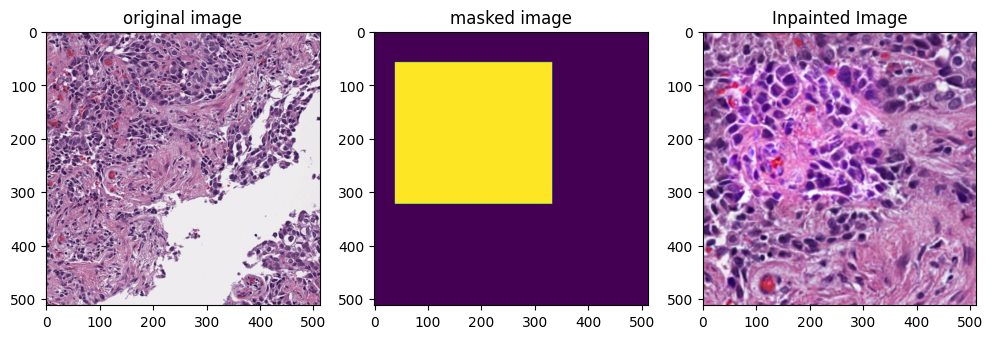

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Create a 1x3 grid for displaying 3 images

# Display each image on a separate subplot
axes[0].imshow(image)
axes[0].set_title('original image')

axes[1].imshow(mask)
axes[1].set_title('masked image')

axes[2].imshow(output_PIL)
axes[2].set_title('Inpainted Image')

plt.show()